In [ ]:
!pip install pdpbox
!pip install shap
!pip install lime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4338a97cb3bd4e06ccf65a26973394563296ced82cdf3eaf578aeb3c81419a17
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
import shap
from pdpbox import pdp, info_plots
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('preprocessed_data.csv')
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [ ]:
# Parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             param_grid={'classifier__C': [0.01, 0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [ ]:
# Best model
best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}


In [ ]:
# Predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]


In [ ]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      9336
           1       0.58      0.03      0.05       664

    accuracy                           0.93     10000
   macro avg       0.76      0.51      0.51     10000
weighted avg       0.91      0.93      0.91     10000

ROC AUC Score: 0.7968033767460588
Confusion Matrix:
 [[9323   13]
 [ 646   18]]


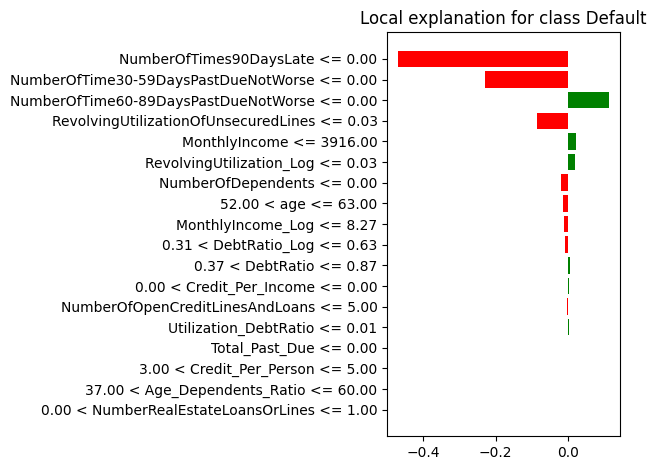

In [ ]:
# LIME
lime_explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['Non-Default', 'Default'],
    mode='classification'
)

lime_exp = lime_explainer.explain_instance(
    X_test.iloc[0].values,
    best_model.predict_proba,
    num_features=len(X_train.columns)
)

fig = lime_exp.as_pyplot_figure()
plt.tight_layout()
plt.show()

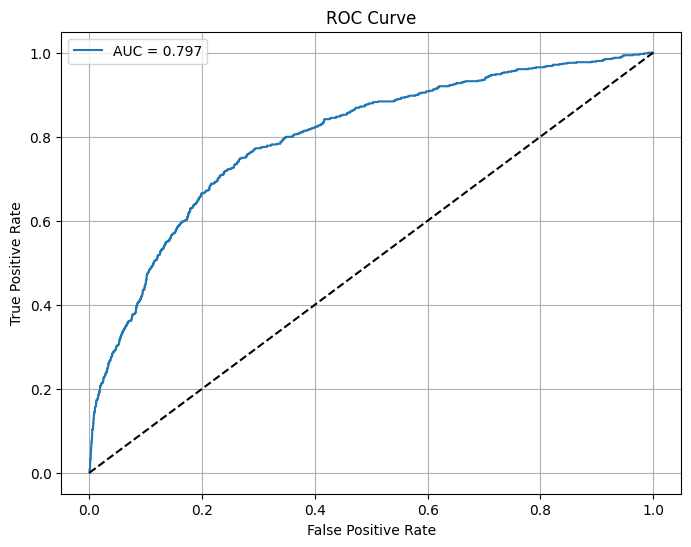

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

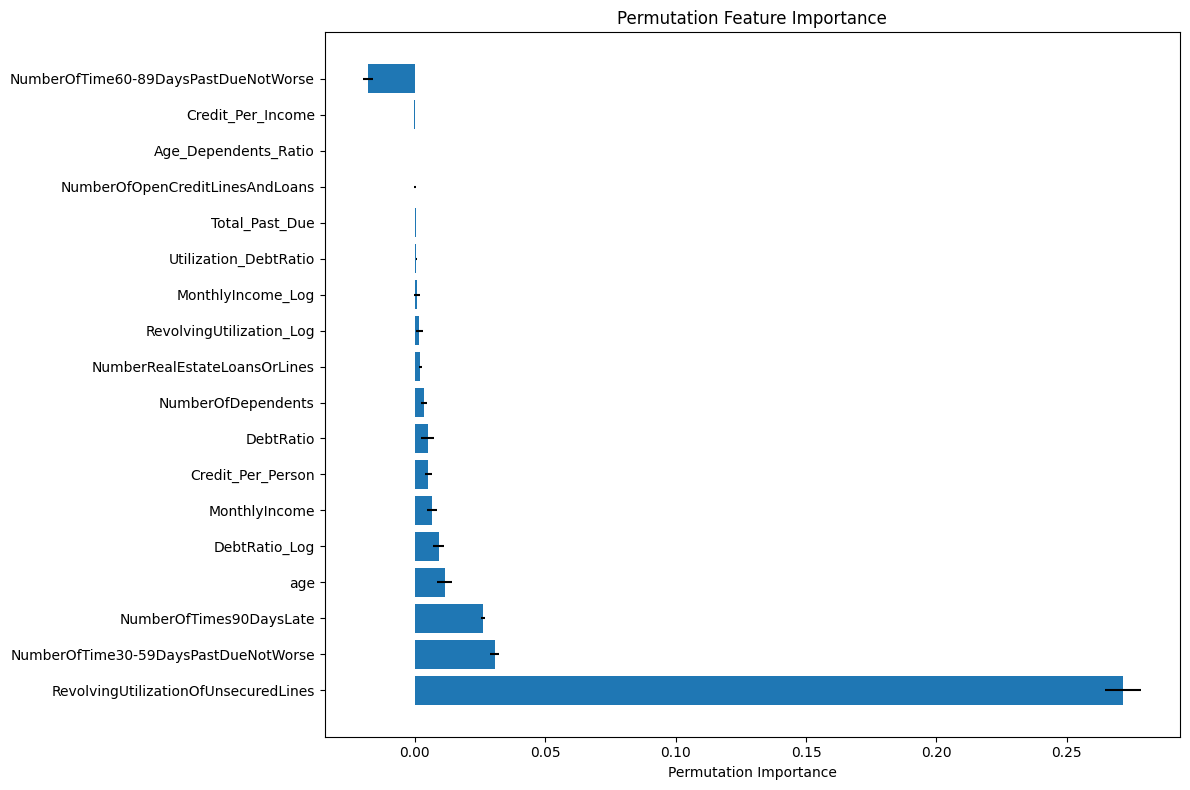

In [ ]:
#  Permutation Importance
perm_importance = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring='roc_auc'
)

perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
})
perm_df = perm_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(perm_df['Feature'], perm_df['Importance'], xerr=perm_df['Std'])
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

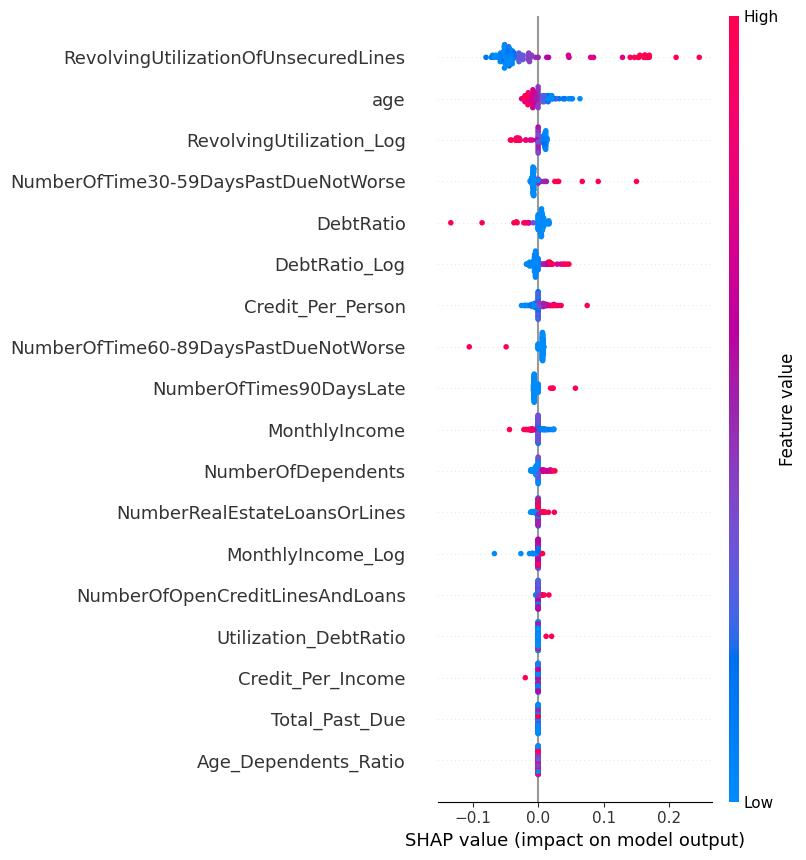

In [ ]:

#  SHAP for Logistic Regression
def model_predict(X):
    return best_model.predict_proba(X)[:, 1]

X_train_summary = shap.sample(X_train, 100, random_state=42)
explainer = shap.KernelExplainer(model_predict, X_train_summary)
shap_values = explainer.shap_values(X_test.iloc[:100])

shap.summary_plot(shap_values, X_test.iloc[:100])


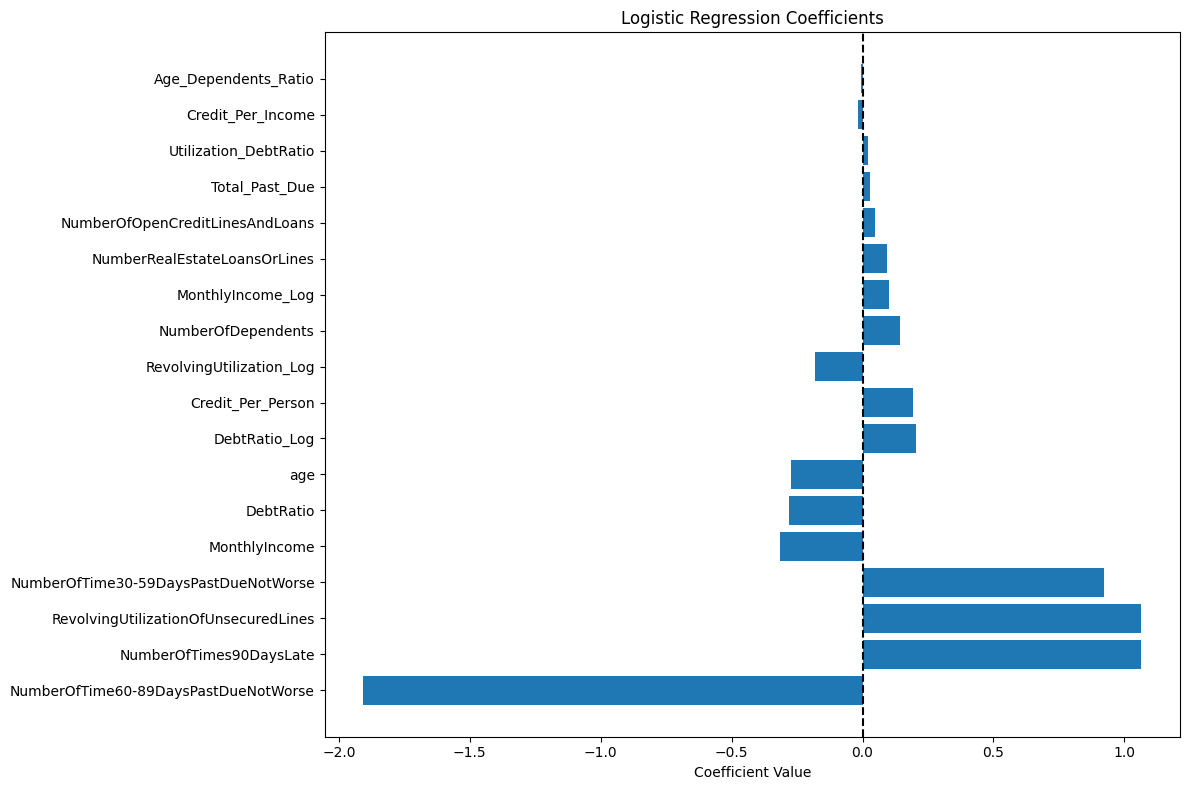

In [ ]:
#  Feature Importance using coefficients

coefficients = best_model.named_steps['classifier'].coef_[0]
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})
feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.axvline(x=0, color='k', linestyle='--')
plt.tight_layout()
plt.show()